# Tracking Single Batters on Fangraphs

### MSP 8.16.2017

Goals:
1. Classify hitters for strategic value
2. Study individual matchups
3. Quantify volatility

In [ ]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import matplotlib as mpl



In [2]:
# imports for scraping

from bs4 import BeautifulSoup
import requests


# basic birth year reader. tables[1] has good stuff in it!
def get_birth_year(tables):

    birthdate_start = (tables[1].text).find("Birthdate:")

    birthdate_end =  (tables[1].text).find('(',birthdate_start)

    #print (tables[1].text)[birthdate_start:birthdate_end]
    birth_year = (tables[1].text)[birthdate_start:birthdate_end].split('/')[2]
    #print birth_year
    
    return birth_year





In [47]:
# the listing of the teams of interest (all!)

teams = ['angels','astros','athletics','bluejays','braves',\
        'brewers','cardinals','cubs','diamondbacks','dodgers',\
        'giants','indians','mariners','marlins','mets','nationals',\
        'orioles','padres','phillies','pirates','rangers',\
        'rays','reds','redsox','rockies','royals','tigers','twins',\
        'whitesox','yankees']

# verify we got all the teams...
print len(teams)

30


#### Compile Hitters

This cell only needs to be run in the event that player ID numbers change, or new players are added.

In [49]:

HDict = {}

f = open('data/batterdict.dat')

for line in f:
    #print line
    try:
        HDict[(line.split('|')[0]).strip()] = line.split('|')[1]
    except:
        pass
    
    
print('Found {} hitters by scraping teams.'.format(len(HDict.keys())))

Found 881 hitters by scraping teams.


### First Application: Grabbing A Hitters AVG/OBP with age

How does a plot of avg/obp evolve with age?

In [56]:
#
# for an individual player
#'

itable = [u'Season', u'Team', u'G', u'AB', u'PA', u'H', u'1B', \
          u'2B', u'3B', u'HR', u'R', u'RBI', u'BB', u'IBB',\
          u'SO', u'HBP', u'SF', u'SH', u'GDP', u'SB', u'CS', u'AVG']
#             0         1        2    3     4      5     6  \
#            7      8   9       10    11      12     13  \
#            14    15    16    17      18       19      20     21


# these are categories to eliminate
projections = ['Depth Charts','Fans',\
               'Fans (6)','Fans (7)','Fans (11)','Fans (12)','Fans (14)','Fans (15)',\
               'Steamer',\
               'ZiPS', 'ZiPS (R)','Steamer (R)','Depth Charts (R)','Average','Postseason']

minors = ['(AA)','(A)','(AAA)','(R)','(A+)','(A-)']

agg = ['Total','Postseason']



plist = ['Joey Votto','Albert Pujols','Mike Trout']


#for player in HDict.keys():

def obtain_players(plist):
    
    # set up dictionary
    PVals = {}

    pnum = 0

    for player in plist:
        PVals[player] = {}
        #print player,

        get_url = 'http://www.fangraphs.com/statss.aspx?playerid='+str(HDict[player].strip())

        r  = requests.get(get_url)

        data = r.text

        soup = BeautifulSoup(data)

        tables = soup.findAll('table')

        birth_year = float(get_birth_year(tables))

        PVals[player]['age'] = []
        PVals[player]['kr'] = []
        PVals[player]['bbr'] = []
        PVals[player]['babip'] = []


        for indx,table in enumerate(tables):

            #print indx,[th.get_text() for th in table.find("tr").find_all("th")]

            if [th.get_text() for th in table.find("tr").find_all("th")] == itable:

                #print get_url
                print pnum,player

                pnum += 1

                #print [th.get_text() for th in table.find("tr").find_all("th")]

                #print table.find_all("tr", class_="grid_multi")

                for row in table.find_all("tr")[1:]:

                    if (row in table.find_all("tr", class_="grid_postseason")) |\
                        (row in table.find_all("tr", class_="grid_multi")):
                            #print 'Multi and/or Postseason:',sav[0]
                            continue


                    sav = [td.get_text() for td in row.find_all("td")]

                    if (np.sum([(x.strip() in sav[1]) for x in projections])==0) & \
                    (np.sum([(x in sav[1]) for x in minors])==0) & \
                    (np.sum([(x in sav[0]) for x in agg])==0): 
                        try:
                            float(sav[-1])
                            float(sav[0])

                            #print sav[0],sav[1],float(sav[4])>50.

                            # current problem is that postseason is mixed in

                            if (float(sav[4])>50.):
                                # sav[4] is PA
                                PVals[player]['age'].append(float(sav[0])-birth_year)
                                PVals[player]['kr'].append(float(sav[14])/float(sav[4]))
                                PVals[player]['bbr'].append(float(sav[12])/float(sav[4]))

                                # babip = (H-HR)/(AB-K-HR+SF)
                                PVals[player]['babip'].append( (float(sav[5])-float(sav[9]))/\
                                                              (float(sav[3])-float(sav[14])-float(sav[9]) + float(sav[16])))

                            #if (float(sav[7])<50.):
                            #    print 'rejected for too few innings:',sav[0],float(sav[7])

                        except:
                            # this is janky way to skip postseason. please fix this
                            #print 'Skipped for postseason',sav[0],sav[1]
                            pass

    return PVals




0 Charlie Blackmon
1 Paul Goldschmidt
2 Jose Altuve
3 Giancarlo Stanton
4 Aaron Judge
5 Joey Votto
6 Bryce Harper
7 Nolan Arenado


In [59]:


def plot_plist(plist,PVals):

    fig = plt.figure(figsize=(5,3))

    ax3 = fig.add_axes([0.15,0.15,0.7,0.25])
    ax2 = fig.add_axes([0.15,0.40,0.7,0.25])
    ax1 = fig.add_axes([0.15,0.65,0.7,0.25])

    ax4 = fig.add_axes([0.9,0.15,0.02,0.75])

    clrs = cm.gnuplot


    for indx,player in enumerate(plist):
        ax1.plot(PVals[player]['age'],PVals[player]['kr'],color=cm.gnuplot(indx/float(len(plist)-1.),1.))
        ax2.plot(PVals[player]['age'],PVals[player]['bbr'],color=cm.gnuplot(indx/float(len(plist)-1.),1.))
        ax3.plot(PVals[player]['age'],PVals[player]['babip'],color=cm.gnuplot(indx/float(len(plist)-1.),1.))




    ax3.set_xlabel('Age',size=18)
    ax1.set_ylabel('Ks',size=18)
    ax2.set_ylabel('BBs',size=18)
    ax3.set_ylabel('BABIP',size=18)

    ax2.set_xticklabels(())
    ax1.set_xticklabels(())




    norm = mpl.colors.BoundaryNorm(boundaries=np.linspace(0,1.,len(plist)+1.), ncolors=256)
    cb1 = mpl.colorbar.ColorbarBase(ax4, cmap=cm.gnuplot,norm=norm)
    cb1.set_label('Players',size=16)
    cb1.set_ticks(np.linspace(0.,1.,len(plist)+1.) + 0.5/(len(plist)+1.))
    cb1.set_ticklabels(plist)



### Top 10 Players

0 Charlie Blackmon
1 Paul Goldschmidt
2 Jose Altuve
3 Giancarlo Stanton
4 Aaron Judge
5 Joey Votto
6 Bryce Harper
7 Nolan Arenado


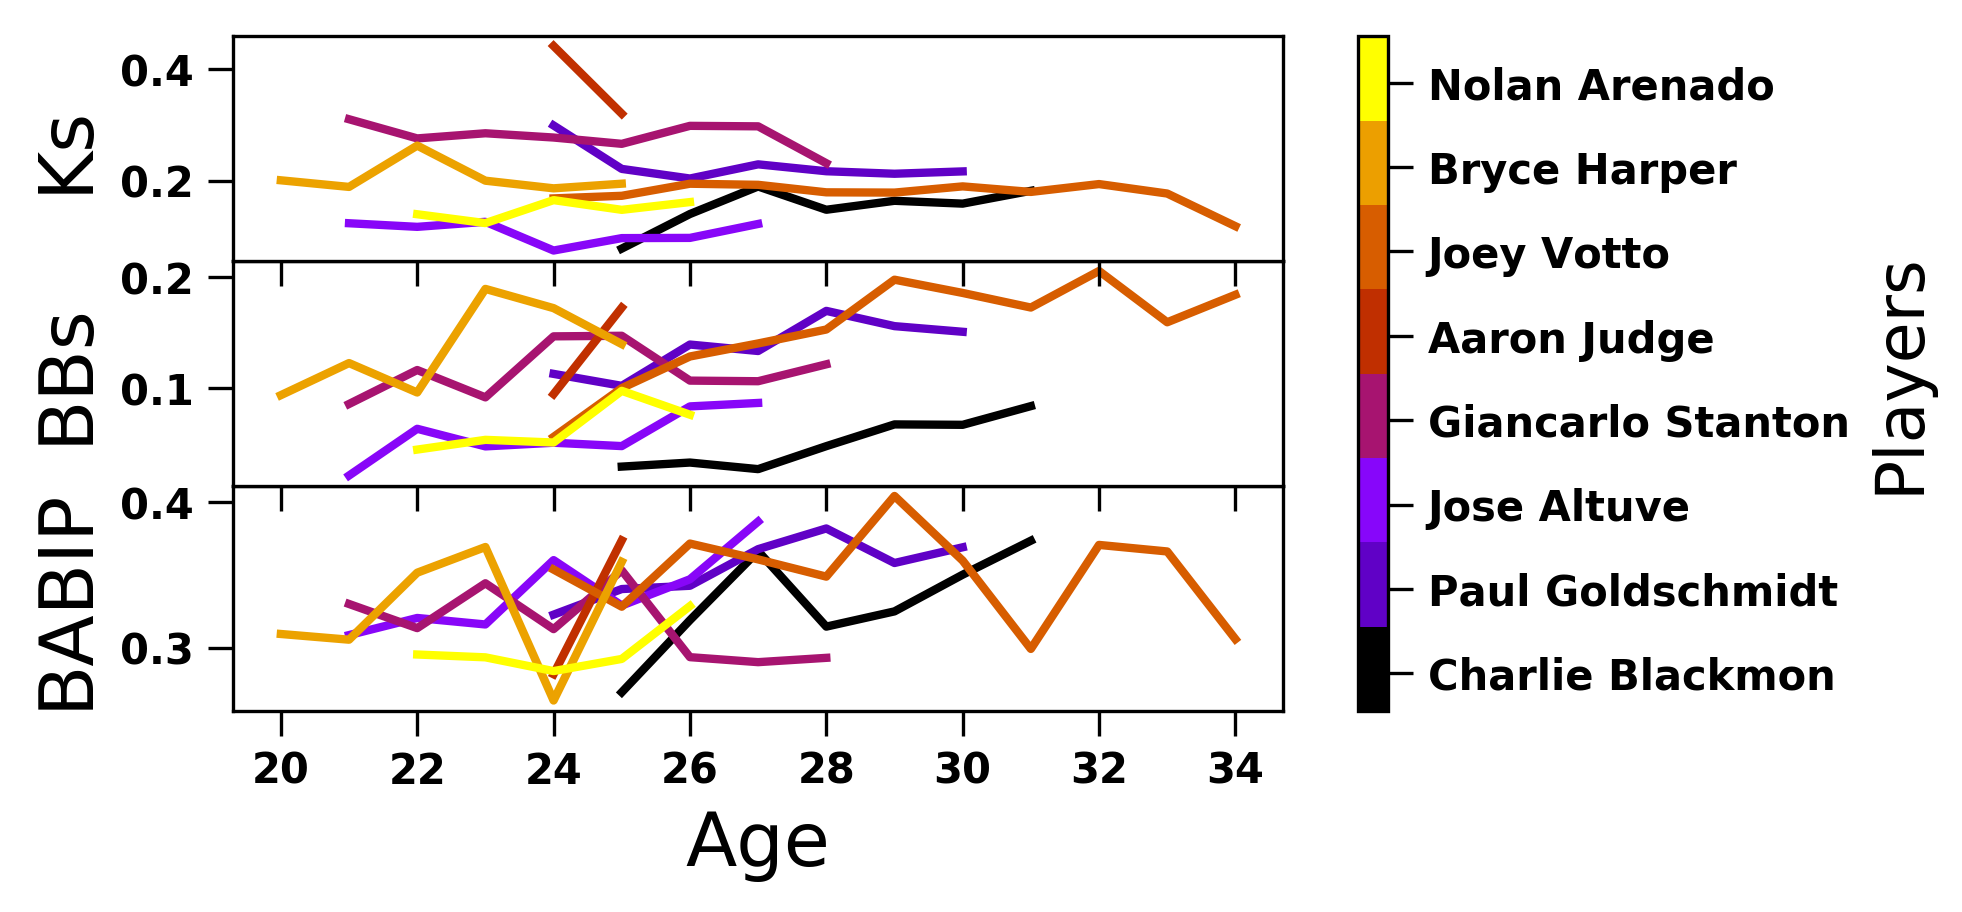

In [60]:

plist = ['Charlie Blackmon','Paul Goldschmidt','Jose Altuve','Giancarlo Stanton',\
         'Aaron Judge','Joey Votto','Bryce Harper','Nolan Arenado']




PVals = obtain_players(plist)
plot_plist(plist,PVals)



### What about some of the older gentlemen?

0 Joey Votto
1 Justin Upton
2 Nelson Cruz
3 Ryan Zimmerman
4 Justin Smoak
5 Andrew McCutchen
6 Daniel Murphy


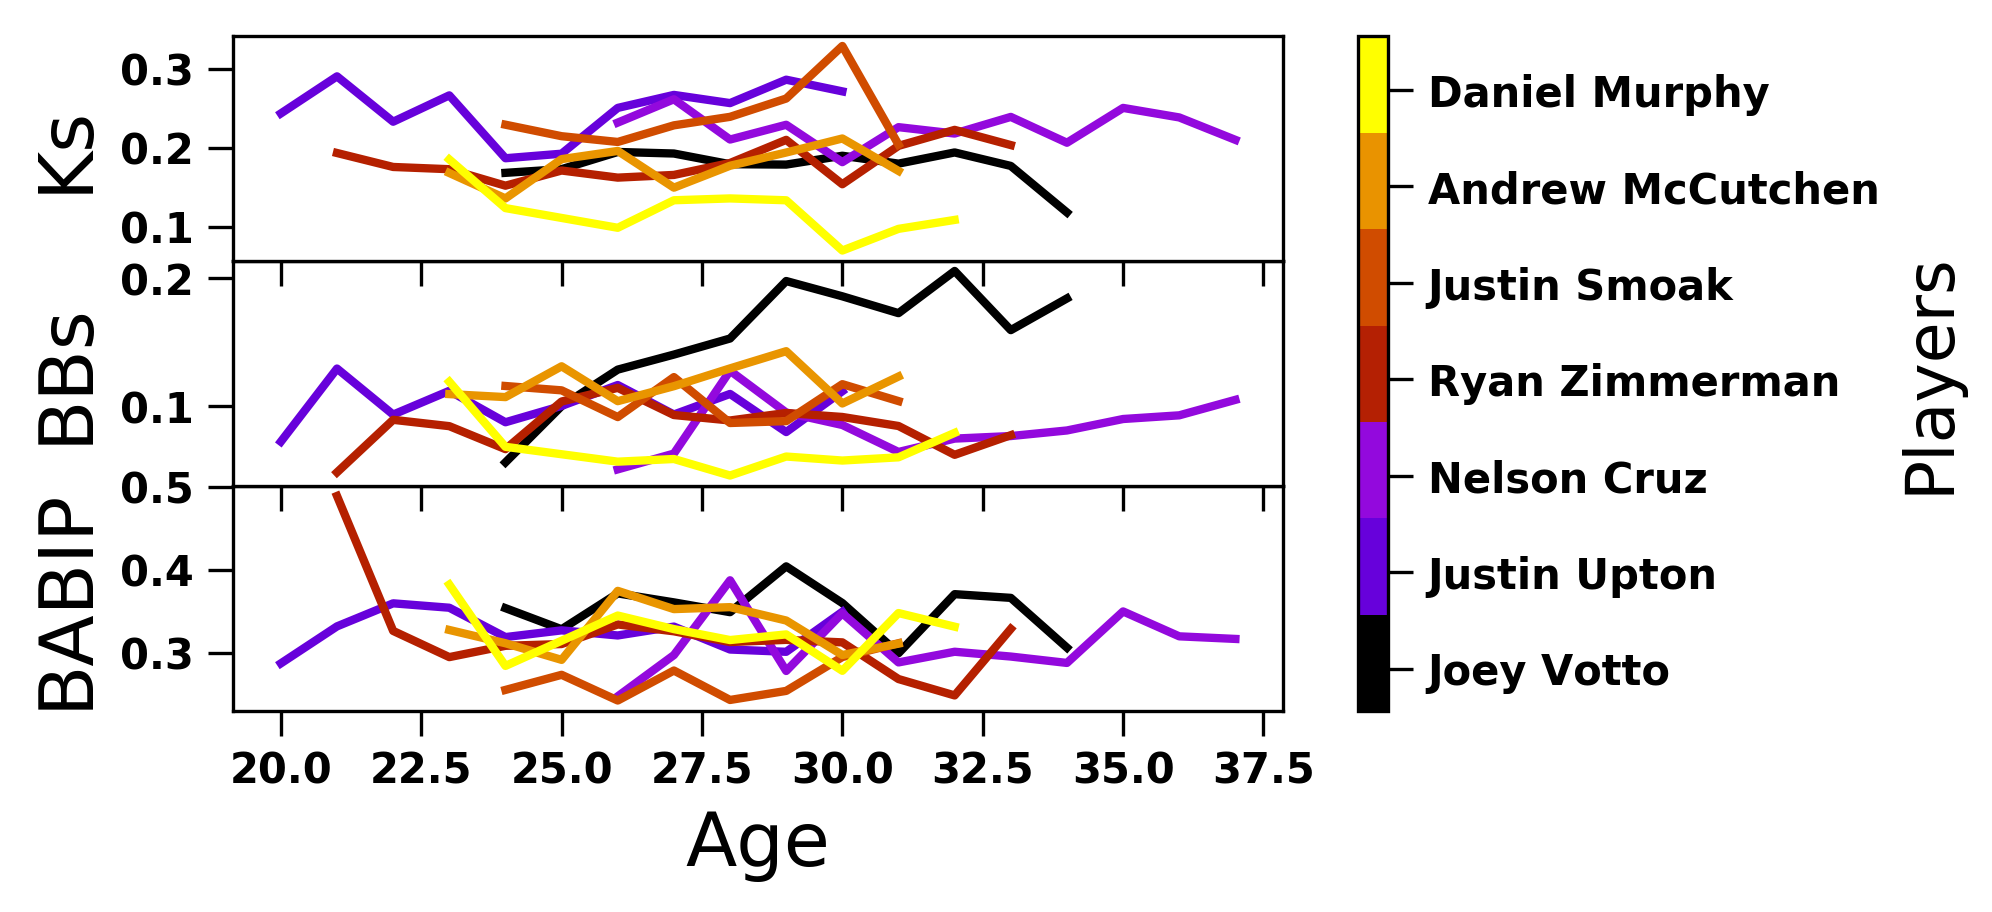

In [78]:
plist = ['Joey Votto','Justin Upton','Nelson Cruz','Ryan Zimmerman','Justin Smoak','Andrew McCutchen','Daniel Murphy']

PVals = obtain_players(plist)

plot_plist(plist,PVals)

### Year Stats

It's also interesting to check on where the numbers are at this year.

In [62]:
PValsFull = obtain_players(HDict.keys())

0 Rougned Odor
1 Giovanny Urshela
2 Kevan Smith
3 Dominic Smith
4 Rafael Devers
5 Keon Broxton
6 Ryan LaMarre
7 Matt Joyce
8 Michael Morse
9 J.T. Realmuto
10 Jae-Gyun Hwang
11 Christian Vazquez
12 Carlos Moncrief
13 A.J. Pollock
14 Tyler Naquin
15 Albert Pujols
16 Jordan Luplow
17 Robbie Grossman
18 Cesar Puello
19 Kirk Nieuwenhuis
20 Jason Castro
21 Sean Rodriguez
22 Scott Schebler
23 Nick Ahmed
24 Elvis Andrus
25 Bruce Maxwell
26 Matt Olson
27 Jared Hoying
28 Josh Reddick
29 Juan Centeno
30 Matt Chapman
31 Teoscar Hernandez
32 Gavin Cecchini
33 Marcus Semien
34 Adam Eaton
35 Danny Ortiz
36 Dustin Garneau
37 Hernan Perez
38 Eugenio Suarez
39 Tom Murphy
40 Mike Trout
41 Miguel Montero
42 Leonys Martin
43 Alejandro De Aza
44 Tyler Austin
45 Tim Beckham
46 Peter Bourjos
47 Yolmer Sanchez
48 Melky Cabrera
49 Brandon Drury
50 James McCann
51 Tim Federowicz
52 Jurickson Profar
53 Paulo Orlando
54 Miguel Cabrera
55 John Hicks
56 Mike Ohlman
57 Rajai Davis
58 Jorge Alfaro
59 Edwin Encarnacion

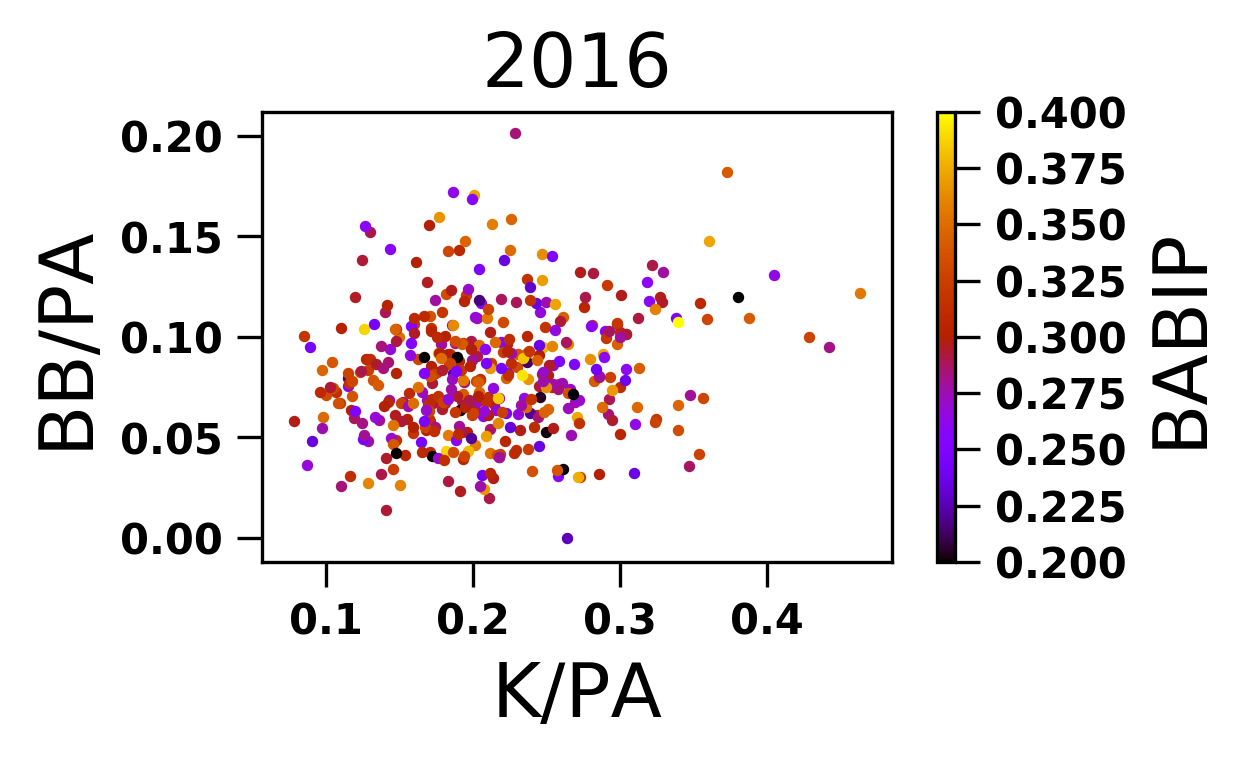

In [75]:
fig = plt.figure(figsize=(3,2))

ax1 = fig.add_axes([0.15,0.15,0.7,0.75])

ax4 = fig.add_axes([0.9,0.15,0.02,0.75])

for player in PValsFull.keys():
    try:
        ax1.scatter(PValsFull[player]['kr'][-2],PValsFull[player]['bbr'][-2],\
                    color=cm.gnuplot(((PValsFull[player]['babip'][-2] - 0.200)/0.200),1.),s=3.)
    except:
        pass
    
    
cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.200, vmax=.400)
cb1 = mpl.colorbar.ColorbarBase(ax4, cmap=cm.gnuplot,norm=norm)
cb1.set_label('BABIP',size=18)

ax1.set_xlabel('K/PA',size=18)
ax1.set_ylabel('BB/PA',size=18)
ax1.set_title('2016',size=18)

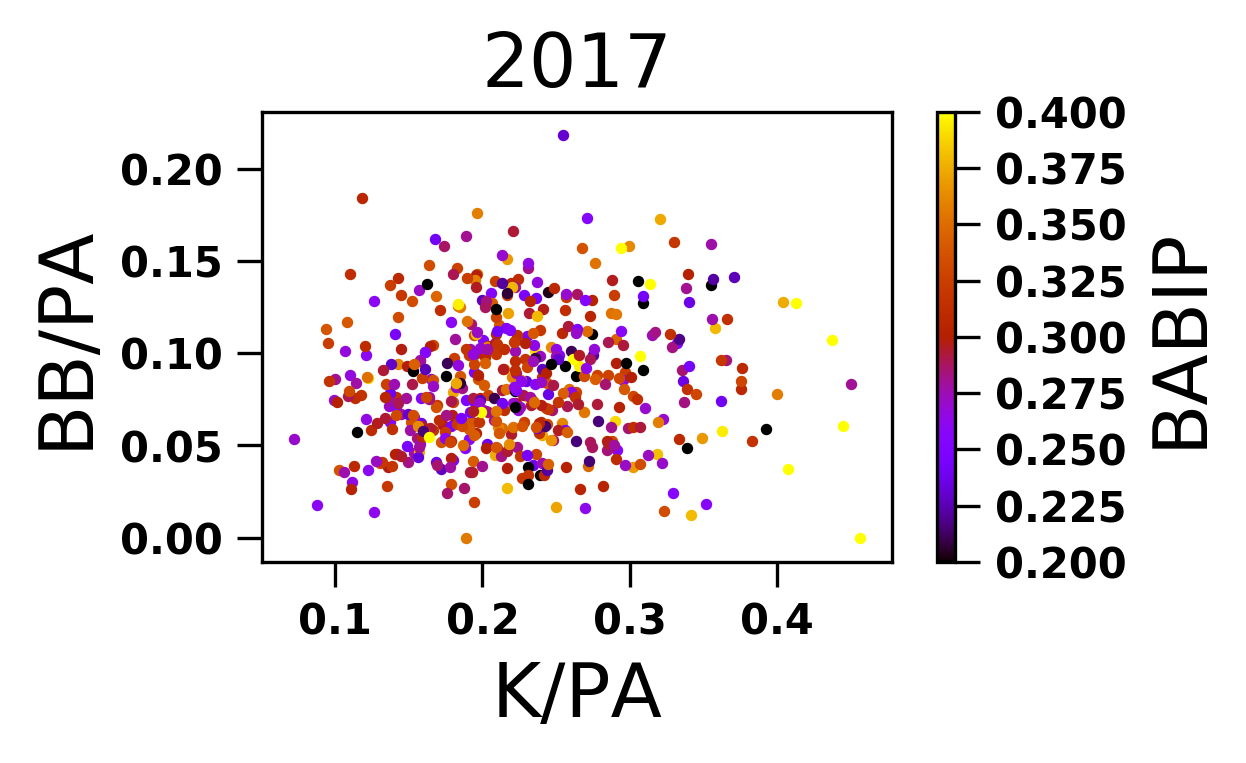

In [76]:
fig = plt.figure(figsize=(3,2))

ax1 = fig.add_axes([0.15,0.15,0.7,0.75])

ax4 = fig.add_axes([0.9,0.15,0.02,0.75])

for player in PValsFull.keys():
    try:
        ax1.scatter(PValsFull[player]['kr'][-1],PValsFull[player]['bbr'][-1],\
                    color=cm.gnuplot(((PValsFull[player]['babip'][-1] - 0.200)/0.200),1.),s=3.)
    except:
        pass
    
    
cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.200, vmax=.400)
cb1 = mpl.colorbar.ColorbarBase(ax4, cmap=cm.gnuplot,norm=norm)
cb1.set_label('BABIP',size=18)

ax1.set_xlabel('K/PA',size=18)
ax1.set_ylabel('BB/PA',size=18)
ax1.set_title('2017',size=18)

Demonstrate the different rows that are available for extracting year-on-year stats.

In [19]:
#
# for an individual player
#

player = 'Tony Watson'


get_url = 'http://www.fangraphs.com/statss.aspx?playerid='+str(HDict[player].strip())

print get_url



projections = ['Depth Charts','Fans (14)','Steamer',\
               'ZiPS', 'ZiPS (R)','Steamer (R)','Depth Charts (R)','Average']

minors = ['(AA)','(A)','(AAA)','(R)','(A+)','(A-)']

agg = ['Total']

r  = requests.get(get_url)

data = r.text

soup = BeautifulSoup(data)


tables = soup.findAll('table')

birth_year = float(get_birth_year(tables))

age = []
k9 = []

for indx,table in enumerate(tables):

    print indx,[th.get_text() for th in table.find("tr").find_all("th")]
   
    if indx==10:
        
        #print [th.get_text() for th in table.find("tr").find_all("th")]
        
        for row in table.find_all("tr")[1:]:
            sav = [td.get_text() for td in row.find_all("td")]
            #if (sav[0]=='2017') & (sav[1] not in projections) & (minors not in sav[1]): print sav
            if (sav[1] not in projections) & \
            (np.sum([(x in sav[1]) for x in minors])==0) & \
            (np.sum([(x in sav[0]) for x in agg])==0): 
                age.append(float(sav[0])-birth_year)
                k9.append(float(sav[2]))
            #print sav[1],np.sum([(x in sav[1]) for x in minors]),
    #        #print sav[0]
            


http://www.fangraphs.com/statss.aspx?playerid=3132
0 []
1 []
2 []
3 []
4 []
5 []
6 []
7 []
8 [u'Season', u'Team', u'W', u'L', u'SV', u'G', u'GS', u'IP', u'K/9', u'BB/9', u'HR/9', u'BABIP', u'LOB%', u'GB%', u'HR/FB', u'ERA', u'FIP', u'xFIP', u'WAR']
9 [u'Season', u'Team', u'W', u'L', u'ERA', u'G', u'GS', u'CG', u'ShO', u'SV', u'HLD', u'BS', u'IP', u'TBF', u'H', u'R', u'ER', u'HR', u'BB', u'IBB', u'HBP', u'WP', u'BK', u'SO']
10 [u'Season', u'Team', u'K/9', u'BB/9', u'K/BB', u'HR/9', u'K%', u'BB%', u'K-BB%', u'AVG', u'WHIP', u'BABIP', u'LOB%', u'ERA-', u'FIP-', u'FIP']


ValueError: could not convert string to float: Postseason

Now we have the ability to automatically grab the stat page for any player!

In [7]:
    
#
# for an individual player
#

player = 'Giancarlo Stanton'


get_url = 'http://www.fangraphs.com/statss.aspx?playerid='+str(HDict[player].strip())

get_url = 'http://www.fangraphs.com/statsd.aspx?playerid=5401&position=P'


projections = ['Depth Charts','Fans (14)','Steamer',\
               'ZiPS', 'ZiPS (R)','Steamer (R)','Depth Charts (R)','Average']

minors = ['(AA)','(A)','(AAA)','(R)','(A+)','(A-)']

agg = ['Total']

r  = requests.get(get_url)

data = r.text

soup = BeautifulSoup(data)


tables = soup.findAll('table')

birth_year = float(get_birth_year(tables))

age = []
k9 = []

for indx,table in enumerate(tables): print indx,[th.get_text() for th in table.find("tr").find_all("th")]
   
#    if indx==10:
#        
#        #print [th.get_text() for th in table.find("tr").find_all("th")]
#        
#        for row in table.find_all("tr")[1:]:
#            sav = [td.get_text() for td in row.find_all("td")]
#            #if (sav[0]=='2017') & (sav[1] not in projections) & (minors not in sav[1]): print sav
#            if (sav[1] not in projections) & \
#            (np.sum([(x in sav[1]) for x in minors])==0) & \
#            (np.sum([(x in sav[0]) for x in agg])==0): 
#                age.append(float(sav[0])-birth_year)
#                k9.append(float(sav[2]))
            #print sav[1],np.sum([(x in sav[1]) for x in minors]),
    #        #print sav[0]
            



0 []
1 []
2 []
3 []
4 []
5 []
6 []
7 [u'S', u'M', u'T', u'W', u'T', u'F', u'S', u'S', u'M', u'T', u'W', u'T', u'F', u'S']
8 [u'S', u'M', u'T', u'W', u'T', u'F', u'S']
9 [u'S', u'M', u'T', u'W', u'T', u'F', u'S']
10 [u'Date', u'Team', u'Opp', u'GS', u'W', u'L', u'SV', u'HLD', u'IP', u'TBF', u'H', u'R', u'ER', u'HR', u'BB', u'SO', u'K/9', u'BB/9', u'HR/9', u'BABIP', u'LOB%', u'GB%', u'HR/FB', u'ERA', u'FIP', u'xFIP', u'GSv2']
